# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)# initialize the score (for each agent)
i=0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    i += 1
    if np.any(dones):                                  # exit loop if episode finished
        print(i)

        break
    
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [4]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
import numpy as np 
import os
import torch
import gym
import matplotlib.pyplot as plt 

class OUActionNoise:
    def __init__(self, mu, sigma=0.075, theta=0.025, dt=1e-2, x0=None):
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.dt = dt
        self.x0 = x0 
        self.reset()
        
    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        
        self.x_prev = x
        
        return x
        
    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu) 

        
class ExperienceBuffer:
    
    def __init__(self, batch_size, buffer_length, state_size, action_size, _reward_size=1, _isdone_size=1):
        
        self.batch_size = batch_size
        self.buffer_length = buffer_length
        self.total_collected_samples = 0
        self.collected_samples = 0
        
        self.current_states = np.array(np.zeros((buffer_length, state_size  )), dtype=np.float32)
        self.next_states    = np.array(np.zeros((buffer_length, state_size  )), dtype=np.float32)
        self.actions        = np.array(np.zeros((buffer_length, action_size )), dtype=np.float32)
        self.rewards        = np.array(np.zeros((buffer_length, _reward_size)), dtype=np.float32)
        self.isdones        = np.array(np.zeros((buffer_length, _isdone_size)), dtype=np.float32)
        
        self.insertion_index = 0
        
    def insert(self, current_state, action, reward, next_state, isdone):
        
        self.current_states[self.insertion_index] = current_state
        self.next_states[self.insertion_index] = next_state
        self.actions[self.insertion_index] = action
        self.rewards[self.insertion_index] = reward
        self.isdones[self.insertion_index] = float(isdone)
        
        self.total_collected_samples += 1
        self.collected_samples = min(self.total_collected_samples, self.buffer_length)
        
        self.insertion_index = self.total_collected_samples % self.buffer_length
            
    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size is None else batch_size

        indices = np.random.choice(min(self.buffer_length, self.collected_samples), batch_size)
        
        return {    'current_states':    self.current_states[indices],
                    'next_states':       self.next_states[indices],
                    'actions':           self.actions[indices],
                    'rewards':           self.rewards[indices],
                    'isdones':           self.isdones[indices]
               }
    
class Critic(torch.nn.Module):
    
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name, chkdir=''):
        super().__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.chk_file = os.path.join(chkdir, name+'_ddpg')
        
        # LAYERS
        self.fc1 = torch.nn.Linear(self.input_dims, self.fc1_dims)
        
        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        
        #self.bn1 = torch.nn.LayerNorm(self.fc1_dims)

        self.action_value = torch.nn.Linear(self.n_actions, self.fc1_dims)

        self.fc2 = torch.nn.Linear(self.fc1_dims, self.fc2_dims)


        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)

        #self.bn2 = torch.nn.LayerNorm(self.fc2_dims)


        self.q = torch.nn.Linear(self.fc2_dims, 1)
        f3 = 0.003
        torch.nn.init.uniform_(self.q.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.q.bias.data, -f3, f3)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.to(self.device)
        
    def forward(self, state, action):
        q_forming_state = self.fc1(state)
        #q_forming_state = self.bn1(q_forming_state)

        q_forming_action = self.action_value(action)

        q_forming = torch.add(q_forming_state, q_forming_action)
        q_forming = torch.nn.functional.relu(q_forming)

        
        q_forming = self.fc2(q_forming)
        #q_forming_state = self.bn2(q_forming_state)

        q_forming = torch.nn.functional.relu(q_forming)
        
        q_forming = self.q(q_forming)
        
        return q_forming
        
    def save_checkpoint(self):
        print('saving checkpoint')
        torch.save(self.state_dict(), self.chk_file)
        
    def load_checkpoint(self):
        print('loading checkpoint')
        torch.load_state_dict(torch.load(self.chk_file)) 
        
class Actor(torch.nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name, chkdir=''):
        super().__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.chk_file = os.path.join(chkdir, name+'_ddpg')
        
        # LAYERS
        self.fc1 = torch.nn.Linear(self.input_dims, self.fc1_dims)
        
        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        
        #self.bn1 = torch.nn.LayerNorm(self.fc1_dims)

        self.fc2 = torch.nn.Linear(self.fc1_dims, self.fc2_dims)

        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)

        #self.bn2 = torch.nn.LayerNorm(self.fc2_dims)

        self.mu = torch.nn.Linear(self.fc2_dims, self.n_actions)
        f3 = 0.003
        torch.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.to(self.device)
    
    def forward(self, state):
        actions_forming = self.fc1(state)
        #actions_forming = self.bn1(actions_forming)
        actions_forming = torch.nn.functional.relu(actions_forming)
        
        actions_forming = self.fc2(actions_forming)
        #actions_forming = self.bn2(actions_forming)
        actions_forming = torch.nn.functional.relu(actions_forming)
        
        actions_forming = self.mu(actions_forming)
        actions_forming = torch.tanh(actions_forming)
        
        return actions_forming

    def save_checkpoint(self):
        print('saving checkpoint')
        torch.save(self.state_dict(), self.chk_file)
        
    def load_checkpoint(self):
        print('loading checkpoint')
        torch.load_state_dict(torch.load(self.chk_file))     
        
class Agent:
    def __init__(self, alpha_actor, alpha_critic, input_dims, tau, env, gamma=0.999, n_actions=2, max_size=100000,
                layer1_size=400, layer2_size=300, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ExperienceBuffer(batch_size=batch_size, buffer_length=max_size, state_size=input_dims, action_size=n_actions)
        self.batch_size = batch_size
        
        self.actor = Actor(alpha_actor, input_dims, layer1_size, layer2_size, n_actions=n_actions, name='Actor')
        self.actor_target = Actor(alpha_actor, input_dims, layer1_size, layer2_size, n_actions=n_actions, name='ActorTarget')
        
        self.critic = Critic(alpha_critic, input_dims, layer1_size, layer2_size, n_actions=n_actions, name='Critic')
        self.critic_target = Critic(alpha_critic, input_dims, layer1_size, layer2_size, n_actions=n_actions, name='CriticTarget')
        
        self.noise = OUActionNoise(mu=np.zeros(n_actions))
        print('initial noise', self.noise())
        
        self.project_parameters_to_targets(tau=1.)
        
    def choose_action(self, state):
        self.actor.eval()
        state = torch.tensor(state, dtype=torch.float).to(self.actor.device)
        with torch.no_grad():
            mu = self.actor(state).to(self.actor.device)
        mu_prime = mu + torch.tensor(self.noise(), dtype=torch.float).to(self.actor.device)
        
        self.actor.train()
        return np.clip(mu_prime.cpu().detach().numpy(), -1, 1)
    
    def remark(self, current_state, action, reward, next_state, isdone): #teljesen felesleges wrapper
        self.memory.insert(current_state, action, reward, next_state,  isdone)

    def learn(self):
        if self.memory.collected_samples >= self.batch_size:
            sampled_data_ = self.memory.sample(self.batch_size)
            
            state0_        = torch.tensor(sampled_data_['current_states'], dtype=torch.float).to(self.critic.device)
            actionset0_    = torch.tensor(sampled_data_['actions'],        dtype=torch.float).to(self.critic.device)
            reward1_       = torch.tensor(sampled_data_['rewards'],        dtype=torch.float).to(self.critic.device)
            state1_        = torch.tensor(sampled_data_['next_states'],    dtype=torch.float).to(self.critic.device)
            isdone_        = torch.tensor(sampled_data_['isdones'],        dtype=torch.float).to(self.critic.device)
            
            #self.actor.eval()            
            #self.actor_target.eval()
            #self.critic_target.eval()
            #self.critic.eval()
            
            actionset1_t_   = self.actor_target(state1_) # t1 [evaled] actionset @ actor target
            q1_t_           = self.critic_target(state1_, actionset1_t_) # t1 [evaled] Q-value @ critic target 
            
            q0_             = self.critic(state0_, actionset0_) # t0 [evaled] Q-value @ critic local
            
            with torch.no_grad(): 
                q0_calc_    = reward1_ + self.gamma * q1_t_ * (1. - isdone_) # t0 [calculated] Q-value @ code
                        
            self.critic.train()
            
            critic_loss = torch.nn.functional.mse_loss(q0_, q0_calc_) # loss function: critic@local <- f(actor@target, critic@target)
            
            self.critic.optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
            self.critic.optimizer.step()
            
            self.critic.eval()
            
            actionset0X_ = self.actor(state0_) # t0 [evaled] actionset @ actor local 
            
            self.actor.train() 
            
            actor_loss = -self.critic(state0_, actionset0X_).mean() # loss function: actor@local <- critic@local
            
            self.actor.optimizer.zero_grad()
            actor_loss.backward()
            self.actor.optimizer.step()
            
            self.project_parameters_to_targets()
            
    def project_parameters_to_targets(self, tau=None):
            tau = self.tau if tau is None else tau
                        
            for local, target in [(self.actor, self.actor_target), (self.critic, self.critic_target)]:
                for local_param, target_param in zip(local.parameters(), target.parameters()):
                    target_param.data.copy_(tau * (local_param.data) + (1. - tau) * target_param.data)  
                    
    def save_models(self):
        for network in [self.actor, self.actor_target, self.critic, self.critic_target]:
            network.save_checkpoint()
        
    def load_models(self):
        for network in [self.actor, self.actor_target, self.critic, self.critic_target]:
            network.load_checkpoint()  

In [6]:
def plot_episode_scores(scores, target):
    plt.plot(scores, color='blue')
    plt.plot(np.hstack([np.empty((100,)) * np.nan, np.convolve(scores, np.ones((100,))/100, mode='valid')[:]]), color='orange')
    plt.plot(np.ones((len(scores),)) * float(target), color='red')
    plt.show()

In [8]:
agent = Agent(alpha_actor=0.000075, alpha_critic=0.0005, input_dims=33, tau=0.001, env=env, 
              batch_size=128, layer1_size=512, layer2_size=256, n_actions=4, gamma=.9)

score_history = []

initial noise [-0.00157716 -0.00920142 -0.0082899   0.00578199]


Epoch: 1... AvgLast100Score: 0.00000...
Epoch: 2... AvgLast100Score: 0.17000...
Epoch: 3... AvgLast100Score: 0.17667...
Epoch: 4... AvgLast100Score: 0.47000...
Epoch: 5... AvgLast100Score: 0.57400...
Epoch: 6... AvgLast100Score: 0.61667...
Epoch: 7... AvgLast100Score: 0.63429...
Epoch: 8... AvgLast100Score: 0.58625...
Epoch: 9... AvgLast100Score: 0.54889...
Epoch: 10... AvgLast100Score: 0.53900...
Epoch: 11... AvgLast100Score: 0.54091...
Epoch: 12... AvgLast100Score: 0.52500...
Epoch: 13... AvgLast100Score: 0.50615...
Epoch: 14... AvgLast100Score: 0.53214...
Epoch: 15... AvgLast100Score: 0.56267...
Epoch: 16... AvgLast100Score: 0.57125...
Epoch: 17... AvgLast100Score: 0.55471...
Epoch: 18... AvgLast100Score: 0.55889...
Epoch: 19... AvgLast100Score: 0.52947...
Epoch: 20... AvgLast100Score: 0.55750...
Epoch: 21... AvgLast100Score: 0.55238...
Epoch: 22... AvgLast100Score: 0.54318...
Epoch: 23... AvgLast100Score: 0.56174...
Epoch: 24... AvgLast100Score: 0.58292...
Epoch: 25... AvgLast100Sc

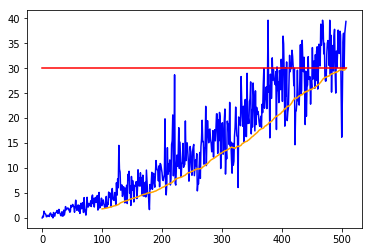

In [9]:
for episode in range(len(score_history), len(score_history)+3000):
    isdone = False
    score = 0
    state0 = env.reset(train_mode=True)[brain_name].vector_observations[0]
    episode_step = 0
    while not isdone:
        actionset0 = agent.choose_action(state0)
        env_response = env.step(actionset0)[brain_name]
        state1, reward1, isdone = env_response.vector_observations[0], env_response.rewards[0], env_response.local_done[0]
        
        if episode_step % 3 == 0:
            agent.remark(state0, actionset0, reward1, state1, isdone)
            agent.learn()
        
        score += reward1
        state0 = state1
        episode_step += 1
    
    score_history.append(score)
    
    if (episode+1) % 1 == 0:
        print('Epoch: {}... AvgLast{}Score: {:.5f}...'.format( \
            episode+1, 
            100,
            np.mean(score_history[-100:])
        ))
    
    if np.mean(score_history[-100:]) > 30.:
        break
                      
print('\nTraining Finished at episode {} !!!\n AvgLast100Score: {:.5f}...'.format(episode+1, np.mean(score_history[-100:])))  
plot_episode_scores(score_history, 30.)

agent.critic.save_checkpoint()
agent.actor.save_checkpoint()
agent.critic_target.save_checkpoint()
agent.actor_target.save_checkpoint()

In [10]:
torch.save(agent.critic.state_dict(), 'cl1.state')
torch.save(agent.critic_target.state_dict(), 'ct1.state')
torch.save(agent.actor.state_dict(), 'al1.state')
torch.save(agent.actor_target.state_dict(), 'at1.state')

In [11]:
np.save('scores1.npy', score_history)